In [94]:
# loading data
import importlib
import load_transform_pipeline #import the module here, so that it can be reloaded.
importlib.reload(load_transform_pipeline)
import pickle
file_path = '../models/data.pkl'
data = pickle.load(open(file_path, 'rb'))

X_train_df = data['X_train_df']
X_test_df = data['X_test_df']
X_val_df = data['X_val_df']

X_train = data['X_train']
X_test = data['X_test']
X_val = data['X_val']

y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']

transform_pipeline = data['transform_pipeline']

In [95]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(40284, 3092)
(17905, 3092)
(13429, 3092)


In [96]:
import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.__version__

'2.1.0'

In [97]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers
from keras import backend as K
from keras.layers import BatchNormalization, Activation, LeakyReLU

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = Sequential()

model.add(Dense(256,input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))


# model.add(Dense(700, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.005)))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.3))

# model.add(Dense(400))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.3))

# model.add(Dense(400))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.3))

# model.add(Dense(700))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.3))

# model.add(Dense(600))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))

model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', r2_keras])
# mean_squared_logarithmic_error
# mean_squared_error
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 256)               791808    
_________________________________________________________________
batch_normalization_55 (Batc (None, 256)               1024      
_________________________________________________________________
activation_43 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_56 (Batc (None, 256)               1024      
_________________________________________________________________
activation_44 (Activation)   (None, 256)             

In [98]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True, verbose=1)
callbacks_list = [early_stopping, reduce_lr]

# model.optimizer.learning_rate.assign(0.001)

history = model.fit(
    X_train,
    np.log(y_train),
    epochs=200,
    batch_size=700,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=(X_val, np.log(y_val)),
)

Train on 40284 samples, validate on 13429 samples
Epoch 1/200
40284/40284 [==============================] - 4s 88us/step - loss: 8.1045 - mae: 1.9223 - r2_keras: -12.7981 - val_loss: 13.7377 - val_mae: 3.5523 - val_r2_keras: -29.0488
Epoch 2/200
40284/40284 [==============================] - 3s 75us/step - loss: 1.3644 - mae: 0.7387 - r2_keras: -1.0936 - val_loss: 7.1479 - val_mae: 2.5613 - val_r2_keras: -14.7976
Epoch 3/200
40284/40284 [==============================] - 3s 85us/step - loss: 1.0673 - mae: 0.6917 - r2_keras: -0.8322 - val_loss: 3.6385 - val_mae: 1.7672 - val_r2_keras: -6.8371
Epoch 4/200
40284/40284 [==============================] - 4s 95us/step - loss: 0.9442 - mae: 0.6596 - r2_keras: -0.6593 - val_loss: 1.8600 - val_mae: 1.1945 - val_r2_keras: -2.7982
Epoch 5/200
40284/40284 [==============================] - 4s 94us/step - loss: 0.8327 - mae: 0.6208 - r2_keras: -0.4710 - val_loss: 1.1744 - val_mae: 0.8540 - val_r2_keras: -1.2743
Epoch 6/200
40284/40284 [===========

40284/40284 [==============================] - 4s 91us/step - loss: 0.2695 - mae: 0.3798 - r2_keras: 0.4502 - val_loss: 0.2264 - val_mae: 0.3214 - val_r2_keras: 0.5549
Epoch 44/200
40284/40284 [==============================] - 4s 90us/step - loss: 0.2632 - mae: 0.3774 - r2_keras: 0.4594 - val_loss: 0.2150 - val_mae: 0.3113 - val_r2_keras: 0.5786
Epoch 45/200
40284/40284 [==============================] - 3s 86us/step - loss: 0.2633 - mae: 0.3759 - r2_keras: 0.4580 - val_loss: 0.2425 - val_mae: 0.3332 - val_r2_keras: 0.5152
Epoch 46/200
40284/40284 [==============================] - 4s 88us/step - loss: 0.2627 - mae: 0.3773 - r2_keras: 0.4599 - val_loss: 0.2210 - val_mae: 0.3182 - val_r2_keras: 0.5629
Epoch 47/200
40284/40284 [==============================] - 4s 95us/step - loss: 0.2631 - mae: 0.3764 - r2_keras: 0.4585 - val_loss: 0.2255 - val_mae: 0.3246 - val_r2_keras: 0.5534

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.00011764899536501615.
Epoch 48/200
40284/40284 [

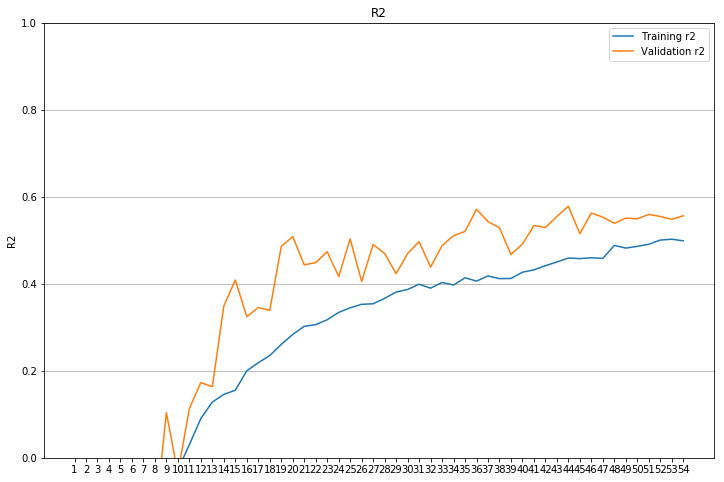

In [99]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
import matplotlib.pyplot as plt

# plt.figure(figsize=(12,8))
# plt.title('LOSS')
# plt.plot(epochs, loss)
# plt.ylim((0, .5))
# plt.plot(epochs, val_loss)
# plt.xticks(ticks=epochs)
# plt.ylabel('Loss')
# plt.legend(['Training loss', 'Validation loss'])
# plt.show()

# mae = history.history['mae']
# val_mae = history.history['val_mae']
# plt.figure(figsize=(12,8))
# plt.title('MAE')
# plt.plot(epochs, mae)
# plt.plot(epochs, val_mae)
# plt.xticks(ticks=epochs)
# plt.ylabel('Mae')
# plt.legend(['Training mae', 'Validation mae'])
# plt.show()


acc = history.history['r2_keras']
val_acc = history.history['val_r2_keras']
plt.figure(figsize=(12,8))
plt.title('R2')
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=epochs)
plt.ylabel('R2')
plt.ylim((0, 1))
plt.legend(['Training r2', 'Validation r2'])
plt.grid(axis='y')
plt.show()

In [39]:
y_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

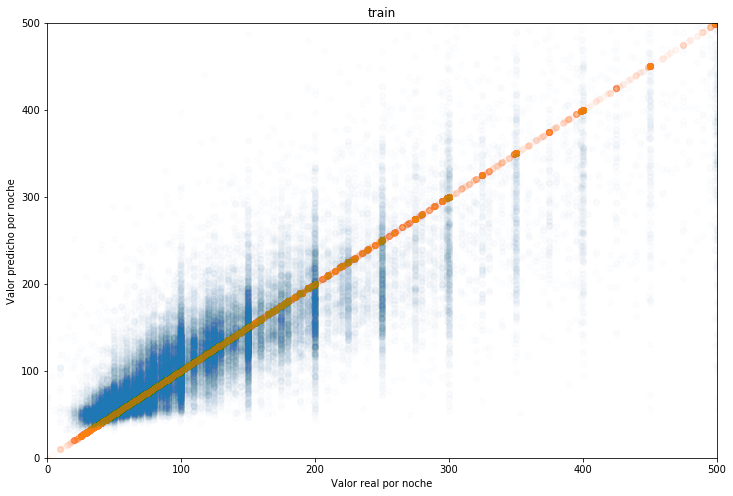

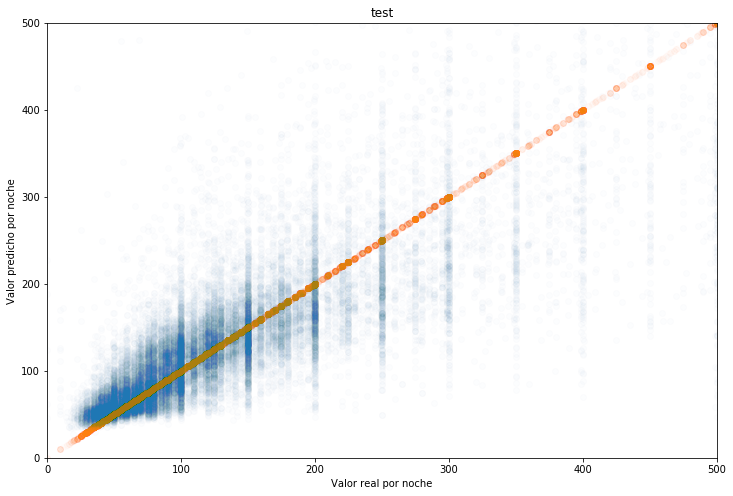

In [40]:
lims = (0, 500)
alpha = .01

plt.figure(figsize=(12,8))
plt.title('train')
plt.scatter(y_train, y_predicted, alpha=alpha)
plt.scatter(y_train, y_train, alpha=alpha)
plt.xlabel('Valor real por noche')
plt.ylabel('Valor predicho por noche')
plt.xlim(lims)
plt.ylim(lims)
plt.show()


plt.figure(figsize=(12,8))
plt.title('test')
plt.scatter(y_test, y_test_predicted[:,0], alpha=alpha)
plt.scatter(y_test, y_test, alpha=alpha)
plt.xlabel('Valor real por noche')
plt.ylabel('Valor predicho por noche')
plt.xlim(lims)
plt.ylim(lims)
plt.show()

In [47]:
df_predicted = X_train_df.copy()
import numpy as np
df_predicted.loc[:, 'price'] = y_train
df_predicted.loc[:, 'predicted'] = y_predicted[:,0]
df_predicted.loc[:, 'pred_ratio'] = y_predicted[:,0] / y_train
df_predicted.loc[:, 'diff'] = y_train - y_predicted[:,0]
df_predicted.loc[:, 'diff_abs'] = np.abs(y_train - y_predicted[:,0])

In [91]:
# df_predicted[['price', 'predicted', 'pred_ratio', 'city2', 'diff_abs']].sort_values('diff_abs')\
# .groupby('city2').apply(np.mean)

from sklearn.metrics import r2_score

for city in df_predicted.city2.unique():
    citydf = df_predicted[df_predicted.city2==city]
    print(city, r2_score(citydf.price, citydf.predicted))
df_predicted

los_angeles 0.7916299277884109
san_diego 0.7429912290626969
new_york_city 0.7594850949462678
austin 0.7488787287340781
new_orleans 0.619809251285415
denver 0.6557451959793743
boston 0.6997220109406084


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city2,predicted,pred_ratio,diff,diff_abs
id,,,,,,,,,,,,,,,,,,,,,
34341370,34341370,https://www.airbnb.com/rooms/34341370,20200313233908,2020-03-14,SunshinePalace VeniceBeach Dream Casa in the T...,My place is close to the beach steps to Venice...,NaN,My place is close to the beach steps to Venice...,none,NaN,...,1,1,0,0,0.36,los_angeles,133.996780,0.957120,6.003220,6.003220
21566928,21566928,https://www.airbnb.com/rooms/21566928,20200313233908,2020-03-14,"Spanish Bungalow w/Pool, Ping Pong & Vinyl",Homey Bungalow hidden from the craziness of LA...,1500 sq foot fully remodeled 3 bed 2 bath with...,Homey Bungalow hidden from the craziness of LA...,none,Our place is close to many great cafés and res...,...,2,1,1,0,1.15,los_angeles,163.281662,0.933038,11.718338,11.718338
17125322,17125322,https://www.airbnb.com/rooms/17125322,20200317212944,2020-03-18,South Park 2BR Cottage 80 Walking Score near Golf,Our cute 2 bedroom Cottage is perfect for coup...,"This 714 square foot house sits on a 2,509 squ...",Our cute 2 bedroom Cottage is perfect for coup...,none,"The closest grocery stores are Target, Fern St...",...,4,4,0,0,1.76,san_diego,143.015472,1.430155,-43.015472,43.015472
685435,685435,https://www.airbnb.com/rooms/685435,20200313233810,2020-03-14,Cozy Private Bedroom $800 Month,Towels and fresh linens will be provided. Util...,"This cozy, spacious bedroom comes with a full ...",Towels and fresh linens will be provided. Util...,none,"The neighborhood offers laundromats, smaller g...",...,1,0,1,0,0.21,new_york_city,54.743080,1.564088,-19.743080,19.743080
9155212,9155212,https://www.airbnb.com/rooms/9155212,20200313233810,2020-03-14,Cozy East Village Room,"Private, cozy bedroom in the East Village, one...","Though small, this room is beloved by all my s...","Private, cozy bedroom in the East Village, one...",none,The East Village /Lower East Side is often cit...,...,1,0,1,0,0.21,new_york_city,85.740753,1.008715,-0.740753,0.740753
8293924,8293924,https://www.airbnb.com/rooms/8293924,20200317143754,2020-03-17,East Austin Modern Farmhouse,"Recently built home in East Austin, just 0.5mi...",We hope you love our newly built modern farmho...,"Recently built home in East Austin, just 0.5mi...",none,Quintessential East Austin neighborhood! We ha...,...,1,1,0,0,0.04,austin,539.821594,0.771174,160.178406,160.178406
24334356,24334356,https://www.airbnb.com/rooms/24334356,20200409140810,2020-04-09,1 block to Streetcar- mins to Quarter,"-Centrally located, bright and spacious New Or...",Steps away from anything you might need- don’t...,"-Centrally located, bright and spacious New Or...",none,Walk less than 1 block to Canal St. Streetcar ...,...,2,1,1,0,2.54,new_orleans,92.453865,1.232718,-17.453865,17.453865
37153544,37153544,https://www.airbnb.com/rooms/37153544,20200313233810,2020-03-14,★ Downtown Manhattan 2BR ★ King Bed ★ Clean&Quiet,"VALUE / COMFORT / LOCATION ✔ 2 Bed Rooms, 1 Ki...","MASTER BEDROOM (One *King* Bed, 1 Twin Single...","VALUE / COMFORT / LOCATION ✔ 2 Bed Rooms, 1 Ki...",none,"The neighborhood, Lower East Side is full of f...",...,1,1,0,0,2.88,new_york_city,241.129196,1.289461,-54.129196,54.129196
1466244,1466244,https://www.airbnb.com/rooms/1466244,20200409140810,2020-04-09,Charming uptown victorian!,Our private and newly remodeled third floor ro...,The newly remodeled bedroom and bath are locat...,Our private and newly remodeled third floor ro...,none,NaN,...,1,0,1,0,1.12,new_orleans,80.576035,0.805760,19.423965,19.423965


In [93]:
df_predicted[['price', 'predicted', 'pred_ratio', 'city2', 'diff_abs', 'listing_url']].sort_values('pred_ratio')

,price,predicted,pred_ratio,city2,diff_abs,listing_url
id,,,,,,
7612717,1000,85.563881,0.085564,los_angeles,914.436096,https://www.airbnb.com/rooms/7612717
2368307,675,66.638588,0.098724,austin,608.361389,https://www.airbnb.com/rooms/2368307
18206718,600,64.901176,0.108169,los_angeles,535.098816,https://www.airbnb.com/rooms/18206718
37994140,800,87.470833,0.109339,los_angeles,712.529175,https://www.airbnb.com/rooms/37994140
26871829,500,54.762318,0.109525,san_diego,445.237671,https://www.airbnb.com/rooms/26871829
7383844,1000,111.236130,0.111236,los_angeles,888.763855,https://www.airbnb.com/rooms/7383844
33757822,900,100.507462,0.111675,los_angeles,799.492554,https://www.airbnb.com/rooms/33757822
33757740,900,102.505997,0.113896,los_angeles,797.494019,https://www.airbnb.com/rooms/33757740
19610766,609,70.349762,0.115517,san_diego,538.650269,https://www.airbnb.com/rooms/19610766
